In [8]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.preprocessing as spre

from itertools import combinations
from kilosort.io import load_probe
from spikeinterface.core import read_binary
from ccg import *

In [9]:
# Main parameters
extract_window = 60
max_value_threshold = 100
redundant_spike_threshold = 60
max_subset_of_spikes = 10000


def xcorrelate_with_amplifier_sampling(x, y, i, j, unsort):
    newx, newy = np.zeros(len(x)*35), np.zeros(len(x)*35)
    # When assigning ones, unsort i and j to get which channels they actually were
    one_inds = np.arange(0, len(x)) * 35
    newx[one_inds + unsort[i]] = x
    newy[one_inds + unsort[j]] = y
    # Fit quadratic for even better max estimation
    corr = np.correlate(newx, newy, mode='same')
    imax = np.argmax(corr)
    userange = np.arange(imax-35*2, imax+35*2)
    fitcorr = corr[userange]
    p = np.polyfit(np.arange(len(newx))[userange[fitcorr != 0]], fitcorr[fitcorr != 0], 2)
    maxest = -p[1] / (2 * p[0])
    return maxest / 35 - (len(x) / 2)


# Common probe details
probe = load_probe('C://Users//lwood39//Documents//ResearchPhD//AutoSpikeSort//A1x32-Poly5-6mm-35s-100_A32_good_kilosort4.prb')
xpos = probe['xc'][np.argsort(probe['chanMap'])]
ypos = probe['yc'][np.argsort(probe['chanMap'])]
# Useful quantities for indexing
xsort = np.argsort(xpos)
unsort = np.zeros_like(xsort)
unsort[xsort] = np.arange(len(xsort))

In [10]:
data_dir = os.path.join('E:', os.sep, 'VNCMP_ephys')
# kilosort_dirs = [x[0] for x in os.walk(data_dir) if 'kilosort4' in x[0] if '.phy' not in x[0]]

dx_dt_units, dx_all, dt_all, amp_all, unit_labels_all = [], [], [], [], []
waves_all, waves_units = [], []
max_unit_id = 0
all_rows = []

kilosort_dir = os.path.join(data_dir, '2025-02-25', 'kilosort4')

# Get details on file
ops = np.load(os.path.join(kilosort_dir, 'ops.npy'), allow_pickle=True).ravel()[0]
fs = ops['fs']
nchan = ops['Nchan']
moth_string = kilosort_dir.split(os.sep)[-2]
# Get times, templates, positions, cluster group
time_spikes = np.load(os.path.join(kilosort_dir, "spike_times.npy"))
unit_spikes = np.load(os.path.join(kilosort_dir, "spike_clusters.npy"))
cluster_group = {}
with open(os.path.join(kilosort_dir, "cluster_group.tsv")) as f:
    for line in f:
        contents = [x.replace('\n', '') for x in line.split('\t')]
        if contents[0].isdigit():
            cluster_group[int(contents[0])] = contents[1]
# Remove any noise units
units = []
unit_labels = {}
for unit in np.unique(unit_spikes):
    if (unit in cluster_group) and (cluster_group[unit] == 'noise'):
        continue
    units.append(unit)
    unit_labels[unit] = cluster_group[unit] if unit in cluster_group else "unlab"
units = np.array(units)

# Extract unit waveforms
waves = {}
mean_waves = {}
# Find binary file
data = read_binary(os.path.join(kilosort_dir, 'temp_wh.dat'), fs, dtype=np.int16, num_channels=32)
# Skip z-scoring, filtering, as temp_wh has all that applied already (as well as drift correction)
for unit in units:
    waveforms = []
    indices = time_spikes[unit_spikes == unit]
    if len(indices) > max_subset_of_spikes:
        indices = indices[np.random.choice(len(indices), max_subset_of_spikes, replace=False)]
    # Remove any redundant/double-counted spikes from manual clustering
    diffinds = np.diff(indices)
    indices = np.delete(indices, np.where(diffinds < redundant_spike_threshold)[0] + 1)
    for i in indices:
        start_ind, end_ind = i - extract_window, i + extract_window
        if (start_ind < 0) or (end_ind > data.get_num_frames()):
            continue
        waveforms.append(data.get_traces(start_frame=start_ind, end_frame=end_ind))
    waves[unit] = np.stack(waveforms, axis=2)
    mean_waves[unit] = waves[unit].mean(axis=2)

# Flip if mean peaks are upside-down
for unit in units:
    if np.abs(mean_waves[unit].max()) < np.abs(mean_waves[unit].min()):
        waves[unit] *= -1
        mean_waves[unit] *= -1

# Amplitude threshold to decide how many shanks units cross
# For each unit get amplitude on each channel
maxvals = np.zeros((units.max()+1, nchan))
for unit in units:
    maxvals[unit,:] = mean_waves[unit].max(axis=0)
maxvals[maxvals < max_value_threshold] = np.nan

In [18]:
# Save images of each unit
fig_dir = os.path.join(kilosort_dir, '..', 'unit_figures')
os.makedirs(fig_dir, exist_ok=True)
for unit in units:
    fig = plt.figure()
    ax = plt.gca()
    values = mean_waves[unit].T
    im = plt.imshow(values[xsort, :])
    fig.colorbar(im, ax=ax)
    ax.set_title(f'Unit {unit}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Channel')
    fig.savefig(os.path.join(fig_dir, f'unit{unit}_globalunit{unit+max_unit_id}.png'))
    plt.close()

136
144


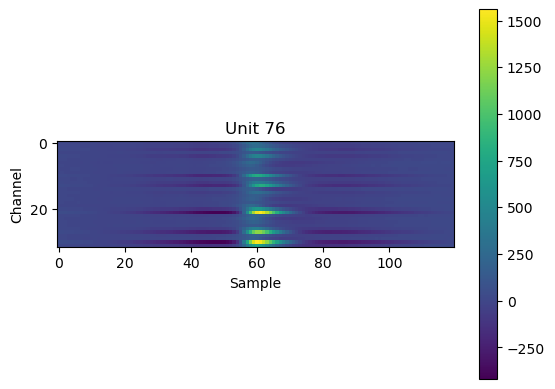

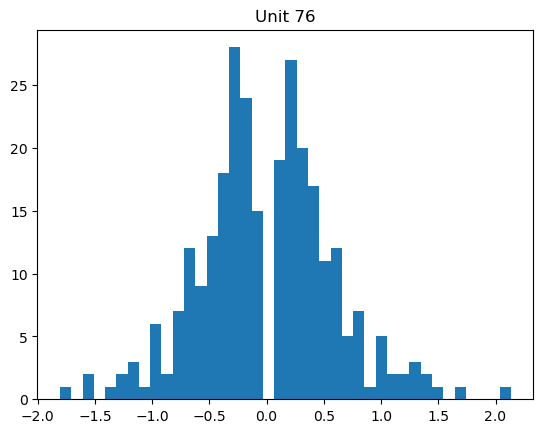

In [15]:
from scipy.stats import binomtest
unit = np.random.choice(units)
# unit = 10

fig = plt.figure()
ax = plt.gca()
values = mean_waves[unit].T
im = plt.imshow(values[xsort, :])
fig.colorbar(im, ax=ax)
ax.set_title(f'Unit {unit}')
ax.set_xlabel('Sample')
ax.set_ylabel('Channel')


wave = mean_waves[unit][:,xsort].T
dx, dt, amp = [], [], []
# Only operate on channels which meet main amplitude threshold
for i,j in combinations(np.arange(32)[np.logical_not(np.isnan(maxvals[unit,xsort]))], r=2):
    thisdx = xpos[xsort][i] - xpos[xsort][j]
    thisdt = xcorrelate_with_amplifier_sampling(wave[i,:], wave[j,:], i, j, unsort)
    # Avoid identical channels, channels at same x position, or time differences smaller than 1 sample
    if (i == j) or (thisdx == 0) or (np.abs(thisdt) < 0.9):
        continue
    dx.append(thisdx)
    dt.append(thisdt)
    amp.append(np.array([wave[i,:].max(), wave[j,:].max()]))
dx = np.array(dx)
dt = np.array(dt) / fs / 1e-6

plt.figure()
# plt.plot(dx, dt, '.')
plt.hist(dx / dt, bins=40)
plt.gca().set_title(f'Unit {unit}')
vel = dx / dt
print(np.sum(vel > 0))
print(np.sum(vel < 0))